In [1]:
%load_ext autoreload
%autoreload 2

# First step, import libraries.
import numpy as np 
import pandas as pd 
import seaborn as sb
from matplotlib import pyplot as plt
from utils import DatasetV1
%matplotlib inline

In [2]:
DATA_PATH = "../data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv"
PRED_DAYS = 30  # num prediction days for the trained models
TIME_GRAN = 10  # time granularity in minutes
STEP_SIZE = 85

### Preprare Data

 > There are 145908 rows
     Timestamp   Open   High    Low  Close  Volume_(BTC)  Volume_(Currency)  \
0   1417411980  300.0  300.0  300.0  300.0          0.01                3.0   
10  1417412580  300.0  300.0  300.0  300.0          0.01                3.0   
20  1417413180  300.0  300.0  300.0  300.0          0.01                3.0   
30  1417413780  300.0  300.0  300.0  300.0          0.01                3.0   
40  1417414380  300.0  300.0  300.0  300.0          0.01                3.0   

    Weighted_Price        Date      Time  
0            300.0  2014-12-01  05:33:00  
10           300.0  2014-12-01  05:43:00  
20           300.0  2014-12-01  05:53:00  
30           300.0  2014-12-01  06:03:00  
40           300.0  2014-12-01  06:13:00  
 Train data size 1415880
 Test data size 43200


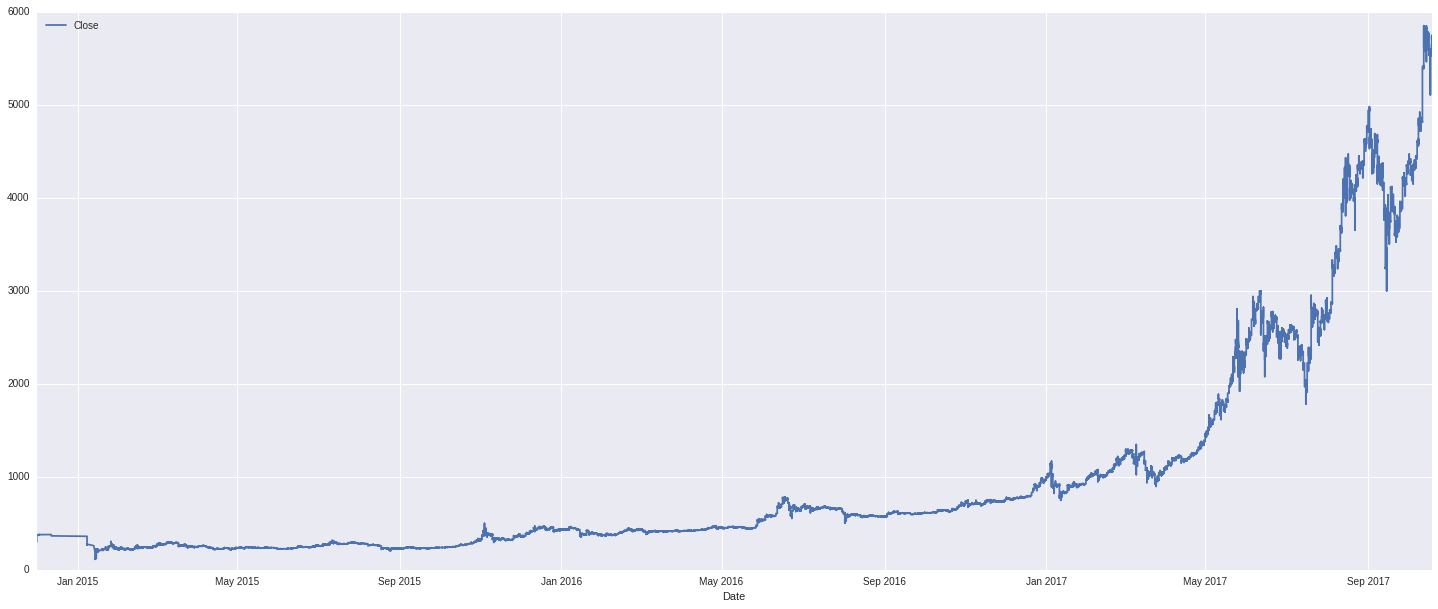

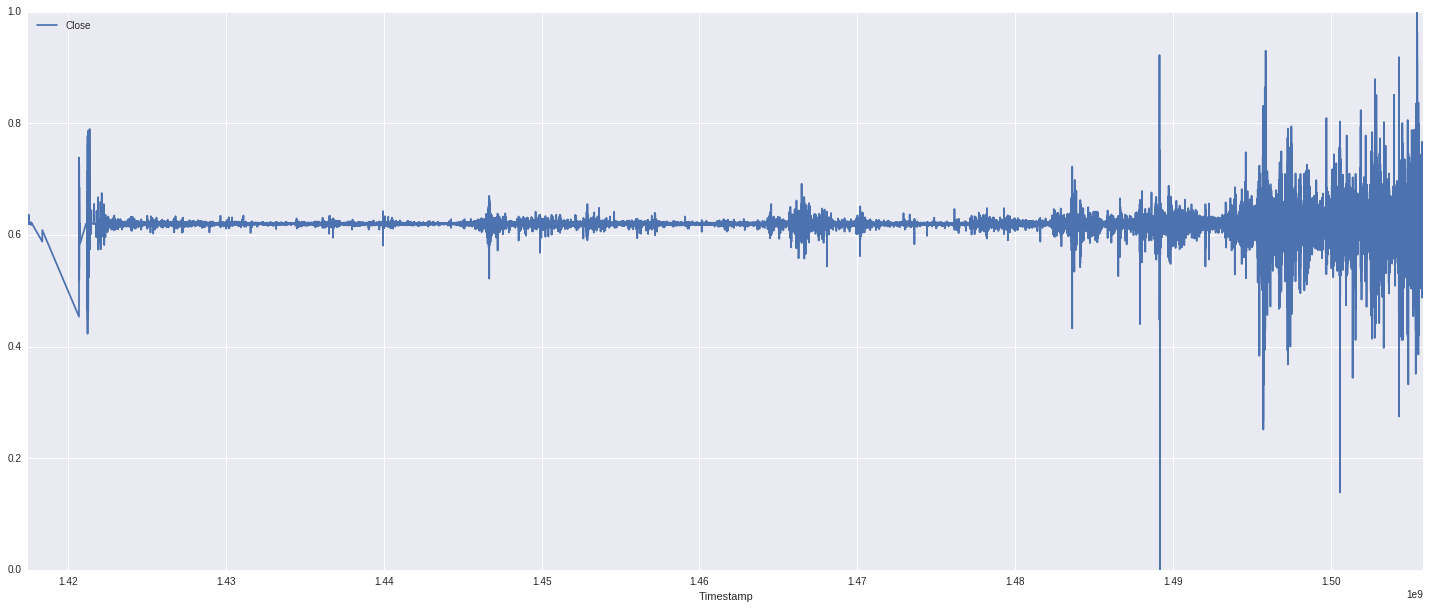

In [127]:
num_test_steps = ((24*60) / TIME_GRAN) * PRED_DAYS 
dataset = DatasetV1(DATA_PATH, tstart=num_test_steps,time_gran=10)

dataset.df.plot(x='Date', y='Close', figsize=[25, 10])

# split data
dataset.create_train_data_v3(["Open", "High", "Low", "Close", "Volume_(BTC)", "Volume_(Currency)"],
                              "Close",
                              time_steps=STEP_SIZE,
                              preprocess=True)
dataset.df_train.plot(x='Timestamp', y='Close', figsize=[25, 10])

In [124]:
assert dataset.y_train.shape[0] == dataset.X_train.shape[0]
assert (dataset.y_train[:-1] - dataset.X_train[1:, 3]).sum() == 0

### Train the model

In [128]:
from keras.optimizers import SGD
optimizer = SGD(lr=0.01, momentum=0.8, decay=0.0001, nesterov=True)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [160]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tqdm import tqdm

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(Dense(units=256, activation='relu',input_shape=[dataset.X_train.shape[1]]))
regressor.add(BatchNormalization())
regressor.add(Dense(units=256, activation='relu'))
regressor.add(BatchNormalization())
regressor.add(Dense(units=128, activation='relu'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.5))
# Adding the output layer
regressor.add(Dense(units=1, activation='sigmoid'))

# Compiling the RNN
regressor.compile(optimizer=optimizer, loss='mean_squared_error', )

In [161]:
# Fitting the RNN to the Training set
for i in range(50):
    print(" ---- "+str(i))
    regressor.fit(dataset.X_train, dataset.y_train, epochs=1, batch_size=64, verbose=True, shuffle=True)
    score = regressor.evaluate(dataset.X_test, dataset.y_test, batch_size=64)
    print(" > Test error:{}".format(score))
    regressor.reset_states()

 ---- 0
Epoch 1/1
4032/4234 [===========================>..] - ETA: 0s > Test error:0.0872024998921
 ---- 1
Epoch 1/1
3840/4234 [==========================>...] - ETA: 0s > Test error:0.0496533058538
 ---- 2
Epoch 1/1
3520/4234 [=======================>......] - ETA: 0s > Test error:0.0367974243358
 ---- 3
Epoch 1/1
4160/4234 [============================>.] - ETA: 0s > Test error:0.0219832768098
 ---- 4
Epoch 1/1
4160/4234 [============================>.] - ETA: 0s > Test error:0.00888160486469
 ---- 5
Epoch 1/1
3136/4234 [=====================>........] - ETA: 0s > Test error:0.00349168618195
 ---- 6
Epoch 1/1
3840/4234 [==========================>...] - ETA: 0s > Test error:0.00183028860028
 ---- 7
Epoch 1/1
4224/4234 [============================>.] - ETA: 0s > Test error:0.00141759816349
 ---- 8
Epoch 1/1
3904/4234 [==========================>...] - ETA: 0s > Test error:0.00128588696079
 ---- 9
Epoch 1/1
3712/4234 [=========================>....] - ETA: 0s > Test error:0.001248954

### Testing

In [162]:
from sklearn.metrics import mean_squared_error
regressor.reset_states()

# walk-forward validation on the test data
X_test = dataset.X_train[:10000]
y_test = dataset.y_train[:10000]
preds = []
labels = []
for idx, x_test in enumerate(X_test):
    # make one-step forecast
    x = x_test[None, :]
    yhat = regressor.predict(x, batch_size=1)
    # store forecast
    preds.append(yhat[0][0])
    labels.append(y_test[idx])

print(" >  MSE error: {}".format(mean_squared_error(preds, labels)))

 >  MSE error: 8.03293302749e-05


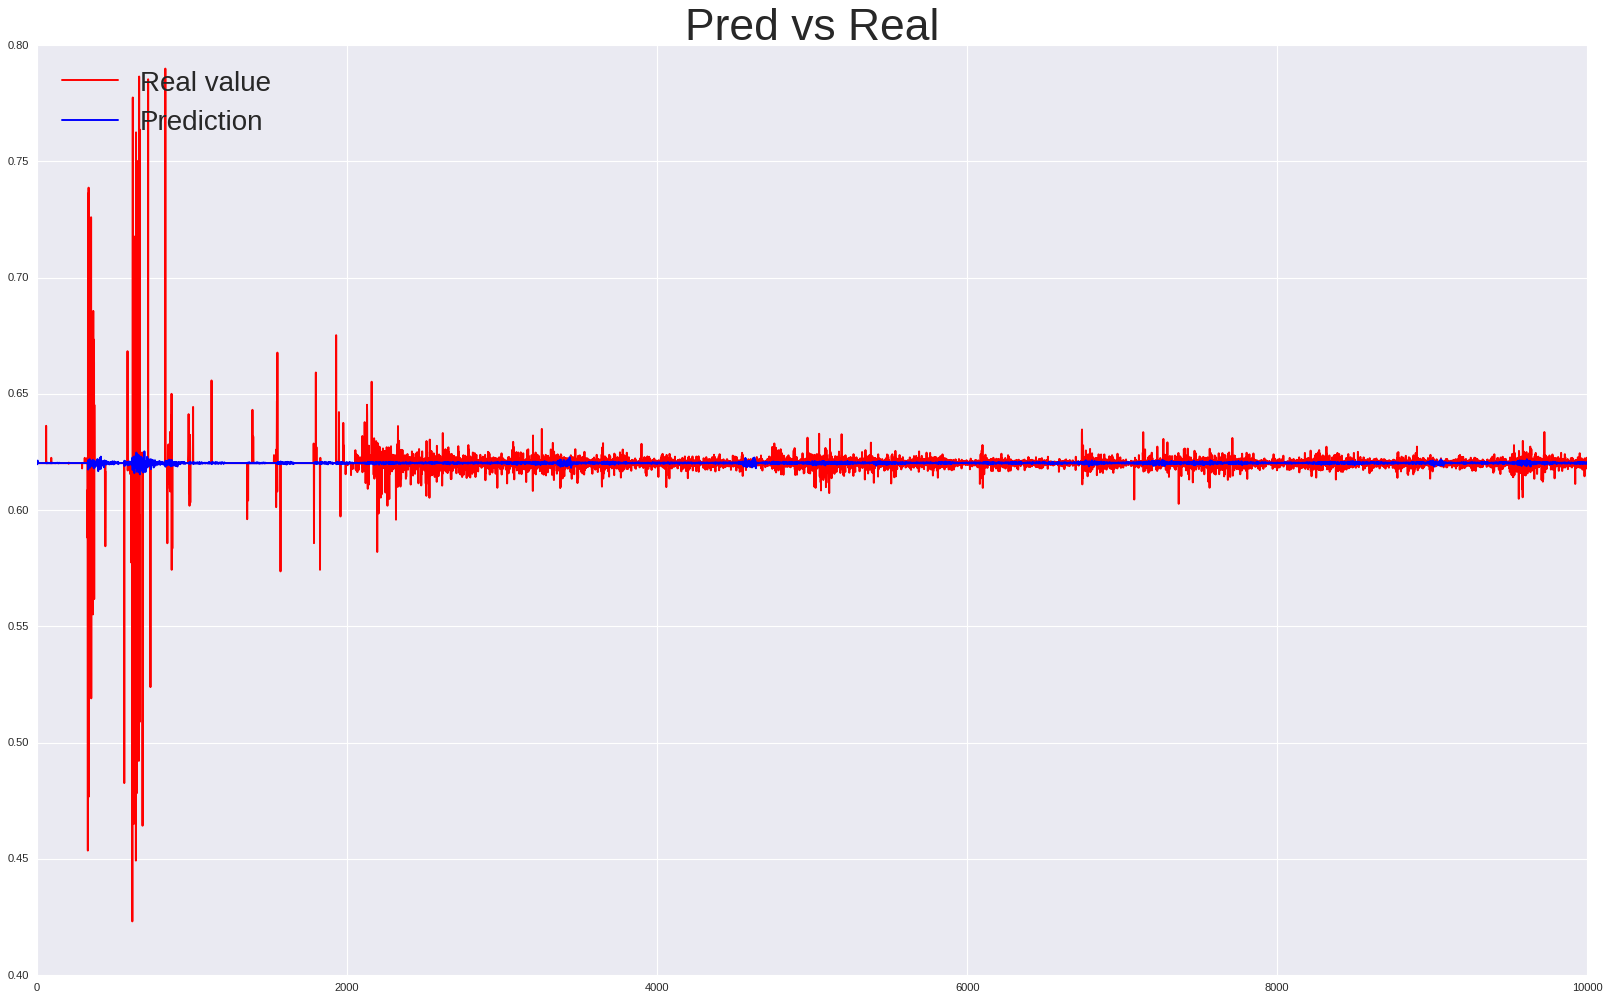

In [163]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  

plt.plot(labels, color = 'red', label = 'Real value')
plt.plot(preds, color = 'blue', label = 'Prediction')

plt.title('Pred vs Real', fontsize=40)
plt.legend(loc=2, prop={'size': 25})

In [164]:
from sklearn.metrics import mean_squared_error
regressor.reset_states()

# walk-forward validation on the test data
X_test = dataset.X_test
y_test = dataset.y_test
preds = []
labels = []
for idx, x_test in enumerate(X_test):
    # make one-step forecast
    x = x_test[None, :]
    yhat = regressor.predict(x, batch_size=1)
    # store forecast
    preds.append(yhat[0][0])
    labels.append(y_test[idx])

print(" >  MSE error: {}".format(mean_squared_error(preds, labels)))

 >  MSE error: 0.0012040015733


In [168]:
np.min(preds)

0.6116184

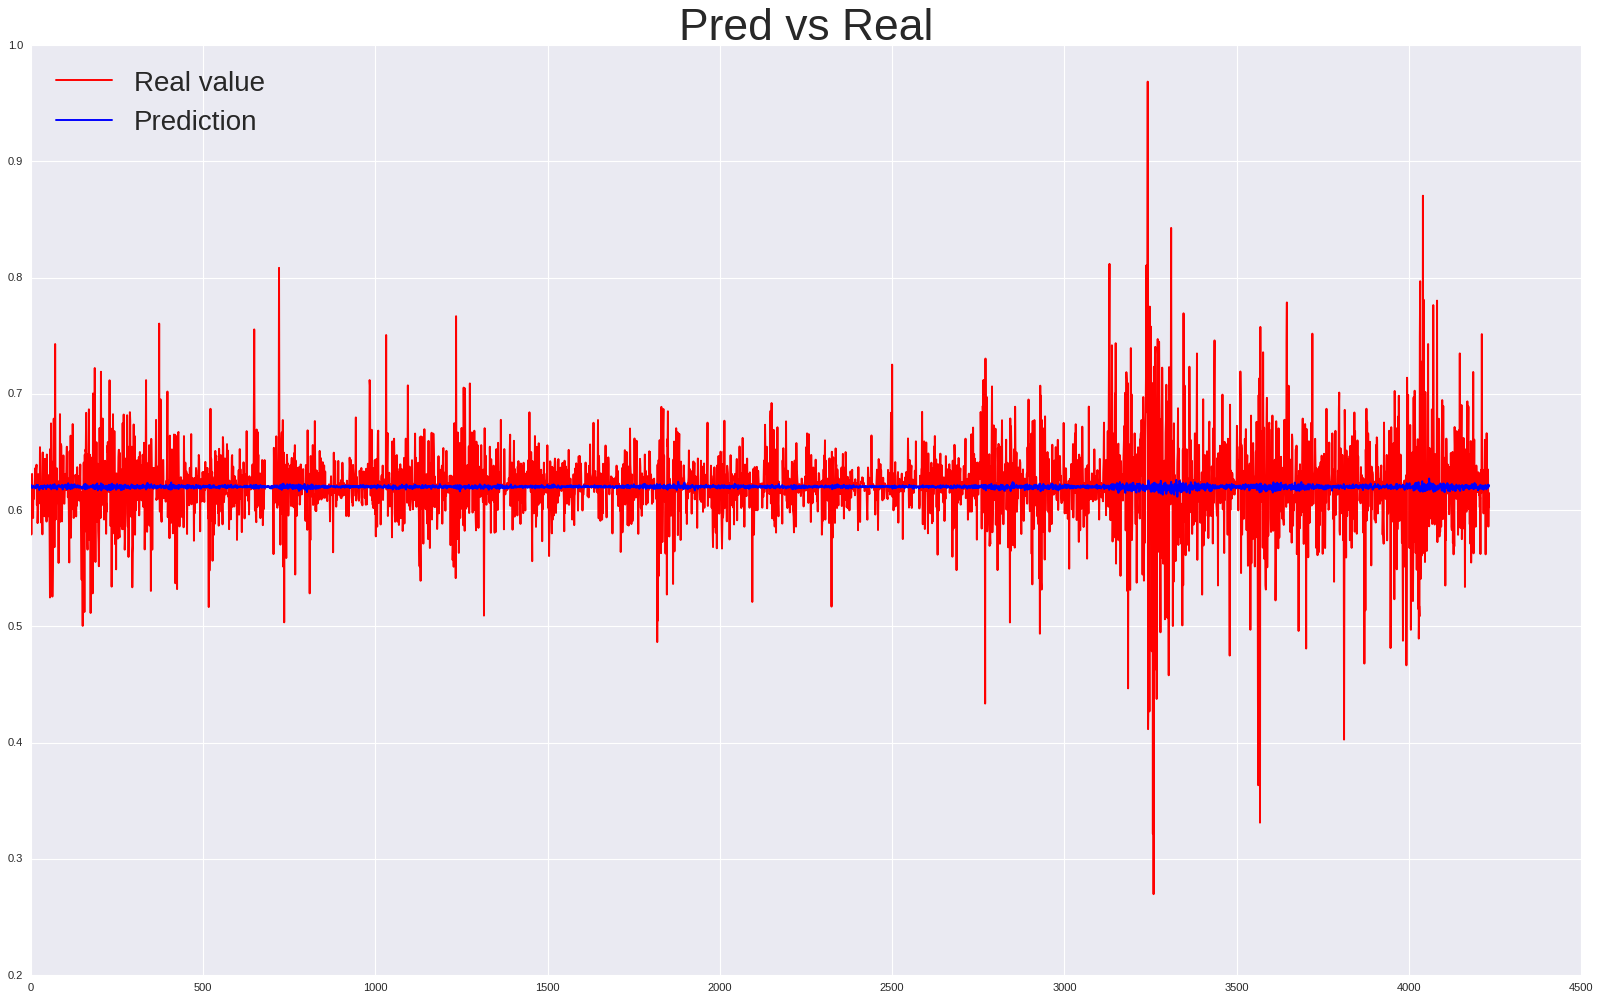

In [165]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  

plt.plot(labels, color = 'red', label = 'Real value')
plt.plot(preds, color = 'blue', label = 'Prediction')

plt.title('Pred vs Real', fontsize=40)
plt.legend(loc=2, prop={'size': 25})

### Try Different Step Sizes

In [17]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.initializers import RandomUniform 
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm


DATA_PATH = "../data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv"
PRED_DAYS = 30  # num prediction days for the trained models
TIME_GRAN = 10  # time granularity in minutes
STEP_SIZES = [25, 50, 100, 200]
scores = [] 

for STEP_SIZE in STEP_SIZES:
    num_test_steps = ((24*60) / TIME_GRAN) * PRED_DAYS 
    dataset = DatasetV1(DATA_PATH, tstart=num_test_steps,time_gran=10)
    dataset.create_train_data_v3(["Open", "High", "Low", "Close", "Volume_(BTC)", "Volume_(Currency)"],
                                  "Close",
                                  time_steps=STEP_SIZE,
                                  preprocess=True)
    optimizer = SGD(lr=0.01, momentum=0.8, nesterov=True)
    initializer = RandomUniform(minval=-1./512, maxval=1./512)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                                  patience=3, min_lr=0.0001)
    save_model = ModelCheckpoint("best_model.h5",
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto',
                                 period=1)
    # Initialising the model
    regressor = Sequential()
    # Adding the input layer and the model layer
    regressor.add(Dense(units=512, activation='relu',kernel_initializer=initializer, input_shape=[dataset.X_train.shape[1]]))
    regressor.add(BatchNormalization())
    regressor.add(Dropout(0.5))
    regressor.add(Dense(units=512, activation='relu',kernel_initializer=initializer))
    regressor.add(BatchNormalization())
    # Adding the output layer
    regressor.add(Dropout(0.5))
    regressor.add(Dense(units=1, activation='sigmoid'))
    # Compiling the model
    regressor.compile(optimizer=optimizer, loss='mean_squared_error', )
    # Fitting the model to the Training set
    regressor.fit(dataset.X_train, dataset.y_train,
                  validation_data=[dataset.X_test, dataset.y_test],
                  epochs=50,
                  batch_size=256,
                  verbose=True,
                  shuffle=True,
                  callbacks=[reduce_lr, save_model])
    
    regressor.load_weights("best_model.h5")
    score = regressor.evaluate(dataset.X_test, dataset.y_test, batch_size=64)
    print(" > Final error:{}".format(score))
    scores.append(score)

 > There are 145908 rows
     Timestamp   Open   High    Low  Close  Volume_(BTC)  Volume_(Currency)  \
0   1417411980  300.0  300.0  300.0  300.0          0.01                3.0   
10  1417412580  300.0  300.0  300.0  300.0          0.01                3.0   
20  1417413180  300.0  300.0  300.0  300.0          0.01                3.0   
30  1417413780  300.0  300.0  300.0  300.0          0.01                3.0   
40  1417414380  300.0  300.0  300.0  300.0          0.01                3.0   

    Weighted_Price        Date      Time  
0            300.0  2014-12-01  05:33:00  
10           300.0  2014-12-01  05:43:00  
20           300.0  2014-12-01  05:53:00  
30           300.0  2014-12-01  06:03:00  
40           300.0  2014-12-01  06:13:00  
 Train data size 1415880
 Test data size 43200
Train on 141562 samples, validate on 4294 samples
Epoch 1/50
141562/141562 [==============================] - 5s - loss: 9.4371e-04 - val_loss: 0.0012
Epoch 2/50
141562/141562 [==================

141562/141562 [==============================] - 4s - loss: 1.9385e-04 - val_loss: 0.0012
Epoch 35/50
141562/141562 [==============================] - 4s - loss: 1.9523e-04 - val_loss: 0.0012
Epoch 36/50
141562/141562 [==============================] - 4s - loss: 1.9493e-04 - val_loss: 0.0012
Epoch 37/50
141562/141562 [==============================] - 4s - loss: 1.9576e-04 - val_loss: 0.0012
Epoch 38/50
141562/141562 [==============================] - 4s - loss: 1.9510e-04 - val_loss: 0.0012
Epoch 39/50
141562/141562 [==============================] - 4s - loss: 1.9544e-04 - val_loss: 0.0012
Epoch 40/50
141562/141562 [==============================] - 4s - loss: 1.9384e-04 - val_loss: 0.0012
Epoch 41/50
141562/141562 [==============================] - 4s - loss: 1.9444e-04 - val_loss: 0.0012
Epoch 42/50
141562/141562 [==============================] - 4s - loss: 1.9414e-04 - val_loss: 0.0012
Epoch 43/50
141562/141562 [==============================] - 4s - loss: 1.9474e-04 - val_loss:

141537/141537 [==============================] - 4s - loss: 1.9373e-04 - val_loss: 0.0012
Epoch 19/50
141537/141537 [==============================] - 4s - loss: 1.9467e-04 - val_loss: 0.0012
Epoch 20/50
141537/141537 [==============================] - 4s - loss: 1.9502e-04 - val_loss: 0.0012
Epoch 21/50
141537/141537 [==============================] - 4s - loss: 1.9379e-04 - val_loss: 0.0012
Epoch 22/50
141537/141537 [==============================] - 4s - loss: 1.9436e-04 - val_loss: 0.0012
Epoch 23/50
141537/141537 [==============================] - 4s - loss: 1.9412e-04 - val_loss: 0.0012
Epoch 24/50
141537/141537 [==============================] - 4s - loss: 1.9498e-04 - val_loss: 0.0012
Epoch 25/50
141537/141537 [==============================] - 4s - loss: 1.9464e-04 - val_loss: 0.0012
Epoch 26/50
141537/141537 [==============================] - 4s - loss: 1.9403e-04 - val_loss: 0.0012
Epoch 27/50
141537/141537 [==============================] - 4s - loss: 1.9488e-04 - val_loss:

141487/141487 [==============================] - 6s - loss: 9.5904e-04 - val_loss: 0.0012
Epoch 2/50
141487/141487 [==============================] - 5s - loss: 2.0205e-04 - val_loss: 0.0012
Epoch 3/50
141487/141487 [==============================] - 5s - loss: 1.9953e-04 - val_loss: 0.0012
Epoch 4/50
141487/141487 [==============================] - 5s - loss: 1.9849e-04 - val_loss: 0.0012
Epoch 5/50
141487/141487 [==============================] - 6s - loss: 1.9767e-04 - val_loss: 0.0012
Epoch 6/50
141487/141487 [==============================] - 5s - loss: 1.9551e-04 - val_loss: 0.0012
Epoch 7/50
141487/141487 [==============================] - 5s - loss: 1.9475e-04 - val_loss: 0.0012
Epoch 8/50
141487/141487 [==============================] - 5s - loss: 1.9392e-04 - val_loss: 0.0012
Epoch 9/50
141487/141487 [==============================] - 5s - loss: 1.9390e-04 - val_loss: 0.0012
Epoch 10/50
141487/141487 [==============================] - 5s - loss: 1.9360e-04 - val_loss: 0.0012


141487/141487 [==============================] - 5s - loss: 1.9375e-04 - val_loss: 0.0012
Epoch 40/50
141487/141487 [==============================] - 5s - loss: 1.9237e-04 - val_loss: 0.0012
Epoch 41/50
141487/141487 [==============================] - 5s - loss: 1.9258e-04 - val_loss: 0.0012
Epoch 42/50
141487/141487 [==============================] - 5s - loss: 1.9274e-04 - val_loss: 0.0012
Epoch 43/50
141487/141487 [==============================] - 5s - loss: 1.9311e-04 - val_loss: 0.0012
Epoch 44/50
141487/141487 [==============================] - 5s - loss: 1.9368e-04 - val_loss: 0.0012
Epoch 45/50
141487/141487 [==============================] - 5s - loss: 1.9365e-04 - val_loss: 0.0012
Epoch 46/50
141487/141487 [==============================] - 5s - loss: 1.9331e-04 - val_loss: 0.0012
Epoch 47/50
141487/141487 [==============================] - 5s - loss: 1.9333e-04 - val_loss: 0.0012
Epoch 48/50
141487/141487 [==============================] - 5s - loss: 1.9278e-04 - val_loss:

141387/141387 [==============================] - 9s - loss: 1.8998e-04 - val_loss: 0.0012
Epoch 24/50
141387/141387 [==============================] - 8s - loss: 1.9165e-04 - val_loss: 0.0012
Epoch 25/50
141387/141387 [==============================] - 9s - loss: 1.9046e-04 - val_loss: 0.0012
Epoch 26/50
141387/141387 [==============================] - 9s - loss: 1.9091e-04 - val_loss: 0.0012
Epoch 27/50
141387/141387 [==============================] - 8s - loss: 1.9081e-04 - val_loss: 0.0012
Epoch 28/50
141387/141387 [==============================] - 9s - loss: 1.9035e-04 - val_loss: 0.0012
Epoch 29/50
141387/141387 [==============================] - 9s - loss: 1.9054e-04 - val_loss: 0.0012
Epoch 30/50
141387/141387 [==============================] - 8s - loss: 1.9043e-04 - val_loss: 0.0012
Epoch 31/50
141387/141387 [==============================] - 9s - loss: 1.9110e-04 - val_loss: 0.0012
Epoch 32/50
141387/141387 [==============================] - 9s - loss: 1.9081e-04 - val_loss:

In [7]:
scores

[0.0011938424009598121,
 0.0012024334344653376,
 0.001207061543593611,
 0.0012130048761334661]

In [11]:
# larger model
scores

[0.0012006004311043066,
 0.0012100937458545599,
 0.0012070556482985354,
 0.0012148991157340339]

In [18]:
# 2 layers dropout
scores

[0.0012001109967997466,
 0.0012004153359063759,
 0.0012066742205190154,
 0.0012105545168098141]

- Larger the time window worser the test accuracy (Does not make sense)